In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import collections 
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Call this function before creating and training your model
set_seeds(42)

In [4]:
# CONSTANT
LEARNING_RATE_VAL = 0.0001
BATCH_SIZE_VAL = 512
VALIDATION_SPLIT_VAL = 0.2
EPOCH_NUMBER = 50

In [5]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=1,              # Number of epochs to wait for improvement
    restore_best_weights=True # Restore model weights from the epoch with the best value
)

### load dataset

In [6]:
def load_np_array(file_name):
    X_array = np.load('data/X_' + file_name + '_array.npy')
    y_array = np.load('data/y_' + file_name + '_array.npy')
    return X_array, y_array

X_train_fall, y_train_fall = load_np_array("train_fall")
X_train_notfall, y_train_notfall = load_np_array("train_notfall")
X_test_fall, y_test_fall = load_np_array("test_fall")
X_test_notfall, y_test_notfall = load_np_array("test_notfall")

In [7]:
print(X_train_fall.shape)
print(y_train_fall.shape)
print(X_train_notfall.shape)
print(y_train_notfall.shape)

(2912, 40, 3)
(2912,)
(2912, 40, 3)
(2912,)


In [8]:
print(X_test_fall.shape)
print(y_test_fall.shape)
print(X_test_notfall.shape)
print(y_test_notfall.shape)

(1456, 40, 3)
(1456,)
(1456, 40, 3)
(1456,)


In [9]:
y_test_fall

array([1, 1, 1, ..., 1, 1, 1])

In [10]:
# Combine fall and non-fall data for training
X_train = np.concatenate((X_train_fall, X_train_notfall), axis=0)
y_train = np.concatenate((y_train_fall, y_train_notfall), axis=0)

# Combine fall and non-fall data for testing
X_test = np.concatenate((X_test_fall, X_test_notfall), axis=0)
y_test = np.concatenate((y_test_fall, y_test_notfall), axis=0)

# Shuffle the training data
train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

# Shuffle the testing data
test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print("Combined training data shape:", X_train.shape, y_train.shape)
print("Combined testing data shape:", X_test.shape, y_test.shape)

Combined training data shape: (5824, 40, 3) (5824,)
Combined testing data shape: (2912, 40, 3) (2912,)


In [11]:
# # Shuffle the training data
# train_indices = np.arange(X_train.shape[0])
# np.random.shuffle(train_indices)
# X_train = X_train[train_indices]
# y_train = y_train[train_indices]

# # Shuffle the testing data
# test_indices = np.arange(X_test.shape[0])
# np.random.shuffle(test_indices)
# X_test = X_test[test_indices]
# y_test = y_test[test_indices]

In [12]:
# Define the GRU model
model = Sequential()
model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2]))) #,return_sequences=True
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_VAL), loss='binary_crossentropy', metrics=['accuracy'])

2024-08-02 00:03:15.883829: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-02 00:03:15.883854: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-02 00:03:15.883860: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-02 00:03:15.883875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-02 00:03:15.883885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Se

In [13]:
# Train the model
history = model.fit(X_train, y_train, epochs=EPOCH_NUMBER, batch_size=BATCH_SIZE_VAL, validation_split=VALIDATION_SPLIT_VAL,callbacks=[early_stopping])#, callbacks=[early_stopping])

Epoch 1/50


2024-08-02 00:03:16.573331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.6919 - loss: 0.6717 - val_accuracy: 0.8103 - val_loss: 0.6479
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7670 - loss: 0.6457 - val_accuracy: 0.8094 - val_loss: 0.6212
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7834 - loss: 0.6215 - val_accuracy: 0.8129 - val_loss: 0.5947
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7880 - loss: 0.5998 - val_accuracy: 0.8129 - val_loss: 0.5671
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.7856 - loss: 0.5749 - val_accuracy: 0.8137 - val_loss: 0.5388
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7906 - loss: 0.5502 - val_accuracy: 0.8137 - val_loss: 0.5110
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7872 - loss: 0.5310 - val_accuracy: 0.8120 - val_loss: 0.4900
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7850 - loss: 0.5183 - val_accuracy: 0.8137 - val_

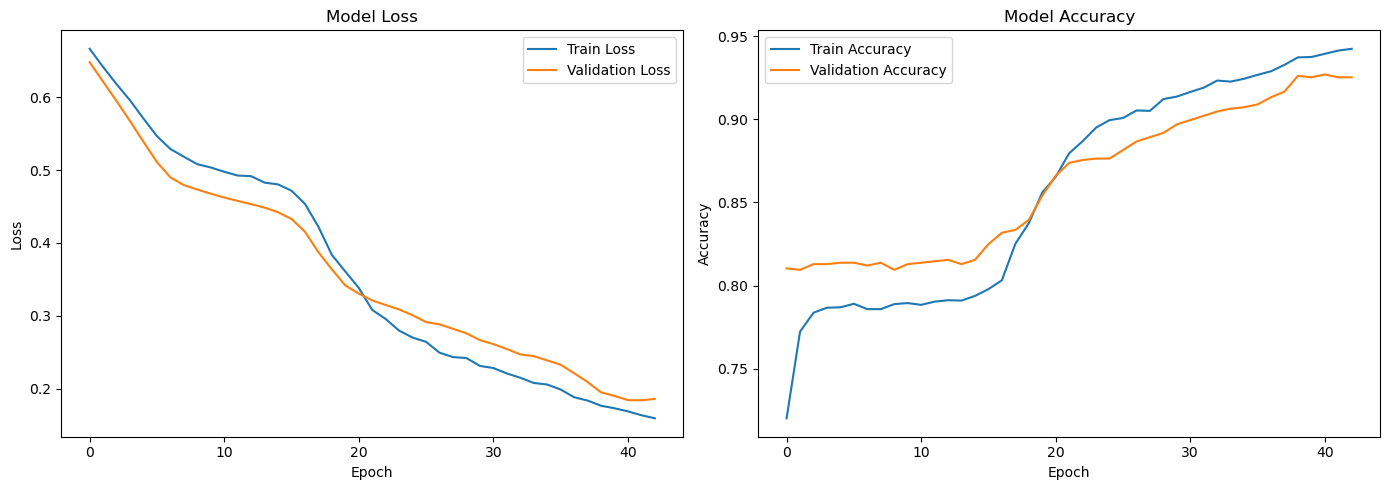

In [14]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Accuracy: 0.9293
Precision: 0.9503
Recall: 0.9059
F1 Score: 0.9276


In [16]:
# Generate and print classification report
report = classification_report(y_test, y_pred, target_names=['Not Fall', 'Fall'])
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

    Not Fall       0.91      0.95      0.93      1456
        Fall       0.95      0.91      0.93      1456

    accuracy                           0.93      2912
   macro avg       0.93      0.93      0.93      2912
weighted avg       0.93      0.93      0.93      2912



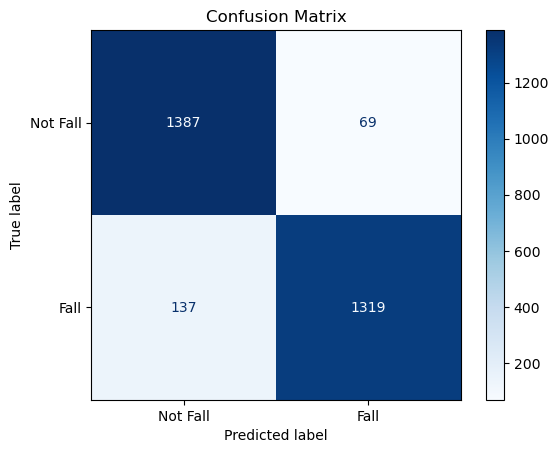

In [17]:
# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fall', 'Fall'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

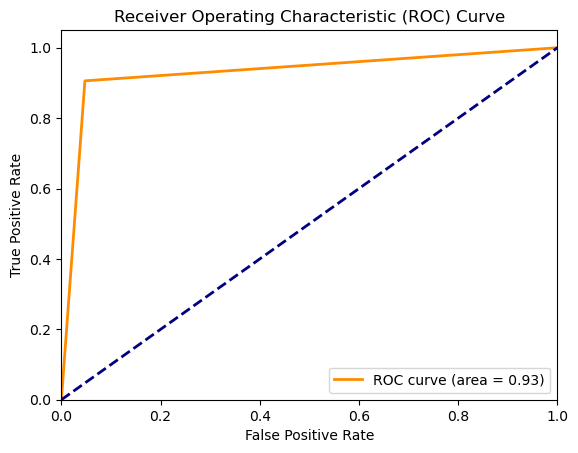

In [18]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()